In [7]:
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow.keras as keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pathlib
import librosa
import librosa.display
# from PIL import Image, ImageOps
from sklearn.model_selection import cross_val_score

In [8]:

'''
Read wav files from SOURCE folder, extract spectrograms in JPG format, and save in TARGET folder
'''

'''
1. Extract spectrograms from wav files
'''


class SpectrogramExtractor:
    def extract(self, SOURCE, TARGET, FIG_SIZE):
        os.chdir(SOURCE)
        for file in os.listdir(SOURCE):
            # load audio file with Librosa
            signal, sample_rate = librosa.load(file, sr=22050)

            # perform Fourier transform (FFT -> power spectrum)
            fft = np.fft.fft(signal)

            # calculate abs values on complex numbers to get magnitude
            spectrum = np.abs(fft)

            # create frequency variable
            f = np.linspace(0, sample_rate, len(spectrum))

            # take half of the spectrum and frequency
            left_spectrum = spectrum[:int(len(spectrum)/2)]
            left_f = f[:int(len(spectrum)/2)]

            # STFT -> spectrogram
            hop_length = 512  # in num. of samples
            n_fft = 2048  # window in num. of samples

            # calculate duration hop length and window in seconds
            hop_length_duration = float(hop_length)/sample_rate
            n_fft_duration = float(n_fft)/sample_rate

            # perform stft
            stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

            # calculate abs values on complex numbers to get magnitude
            spectrogram = np.abs(stft)  # np.abs(stft) ** 2

            # apply logarithm to cast amplitude to Decibels
            log_spectrogram = librosa.amplitude_to_db(spectrogram)

            # Matplotlib plots: removing axis, legends and white spaces
            plt.figure(figsize=FIG_SIZE)
            plt.axis('off')
            librosa.display.specshow(
                log_spectrogram, sr=sample_rate, hop_length=hop_length)

            data_path = pathlib.Path(TARGET)
            file_name = f'{file[0:-4]}.jpg'
            full_name = str(pathlib.Path.joinpath(data_path, file_name))
            plt.savefig(str(full_name), bbox_inches='tight', pad_inches=0)


In [9]:

'''
2. Load training images  
'''
# resize and normalize data for training


def create_training_data(data_path, size=224*4):
    training_data = []
    # for category in CATEGORIES:  # "baseline" and "rattle"

    #     path = os.path.join(data_path, category)  # create path
    #     # get the classification  (0 or a 1). 0=baseline 1=rattle
    #     class_index = CATEGORIES.index(category)

    # iterate over each image
    for image in os.listdir(data_path):
        try:
            data_path = pathlib.Path(data_path)
            full_name = str(pathlib.Path.joinpath(data_path, image))
            data = cv2.imread(str(full_name), 0)
            # resize to make sure data consistency
            resized_data = cv2.resize(data, (size, size))
            # add this to our training_data
            training_data.append([resized_data])
        except Exception as err:
            print("an error has occureC: ", err, str(full_name))

    # normalize data
    training_data = np.array(training_data)/255.
    # reshape
    training_data = np.array(training_data).reshape(-1, size, size)
    return training_data



In [10]:

'''
3. Build autoencoder 
'''
# Define a convolutional Autoencoder


class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        # input layer
        self.latent_dim = latent_dim
        # 1st dense layer
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(224*224, activation='sigmoid'),
            layers.Reshape((224*4, 224*4))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [11]:

'''
4. Set threshold
'''


def threshold(autoencoder, x_train):
    encoded_imgs = autoencoder.encoder(x_train).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    loss = tf.keras.losses.mse(decoded_imgs, x_train)
    threshold = np.mean(loss) + np.std(loss)
    return threshold


In [12]:

'''
5. Make an inference
'''


def spectrogram_loss(autoencoder, spectrogram, size=224*4):
    data = np.ndarray(shape=(1, size, size), dtype=np.float32)
    # individual sample
    # Load an image from a file
    data = cv2.imread(str(spectrogram), 0)
    # resize to make sure data consistency
    resized_data = cv2.resize(data, (size, size))
    # nomalize img
    normalized_data = resized_data.astype('float32') / 255.
    # test an image
    encoded = autoencoder.encoder(normalized_data.reshape(-1, size, size))
    decoded = autoencoder.decoder(encoded)
    loss = tf.keras.losses.mse(decoded, normalized_data)
    sample_loss = np.mean(loss) + np.std(loss)
    return sample_loss


In [13]:

if __name__ == "__main__":

    '''
    2. Load training images
    '''
    # ok
    data_path = "C:/Data/36cc_converted"
    X_train_ok = create_training_data(data_path)
    y_train_ok = np.zeros(int(len(X_train_ok))).astype(int).reshape((-1,1))

    # not_ok
    data_path = "C:/Data/36cc_converted_not_ok"
    X_train_not_ok = create_training_data(data_path)
    y_train_not_ok = np.ones(int(len(X_train_not_ok))).astype(int).reshape((-1,1))

    # concatenate ok and not_ok
    # 데이터 합치기
    # X_train_ok(36)+X_train_not_ok(2)=38
    X = np.concatenate((X_train_not_ok, X_train_ok))
    y = np.concatenate((y_train_not_ok, y_train_ok))

    # test_ok
    data_path = "C:/Data/36cc_converted_test"
    X_train_test_ok = create_training_data(data_path)
    y_train_test_ok = np.zeros(int(len(X_train_test_ok))).astype(int).reshape((-1,1))

    # test_nok
    data_path = "C:/Data/36cc_converted_test_not_ok"
    X_train_test_not_ok = create_training_data(data_path)
    y_train_test_not_ok = np.ones(int(len(X_train_test_not_ok))).astype(int).reshape((-1,1))

    # concatenate ok and not_ok
    # 데이터 합치기
    # X_train_ok(36)+X_train_not_ok(2)=38
    X_train_test = np.concatenate((X_train_test_ok, X_train_test_not_ok))
    y_train_test = np.concatenate((y_train_test_ok, y_train_test_not_ok))

In [14]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder

In [15]:
# #Step1: 모든 문자를 숫자형으로 변환합니다.
# encoder = LabelEncoder()
# encoder.fit(y)
# labels = encoder.transform(y)

# #Step2: 2차원 데이터로 변환합니다.
# labels = labels.reshape(-1, 1)

# #Step3: One-Hot Encoding 적용합니다.
# oh_encoder = OneHotEncoder()
# oh_encoder.fit(labels)
# oh_y = oh_encoder.transform(labels)
# print(oh_y.toarray())
# print(oh_y.shape)

In [16]:


    '''
    3. Build model 
    '''
    def build_model():
        model = keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(1)
        ])
        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
        return model


In [17]:

    # build a simple model with Dense layer
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    model.fit(X, y, epochs=4, batch_size=512)

Epoch 1/4
1/1 [==============================] - 1s 981ms/step - loss: 0.7018 - accuracy: 0.3602
Epoch 2/4
1/1 [==============================] - 0s 29ms/step - loss: 0.3286 - accuracy: 0.9722
Epoch 3/4
1/1 [==============================] - 0s 25ms/step - loss: 0.2079 - accuracy: 0.9722
Epoch 4/4
1/1 [==============================] - 0s 30ms/step - loss: 0.1945 - accuracy: 0.9722


In [18]:
    results = model.evaluate(X_train_test, y_train_test)

1/1 [==============================] - 0s 255ms/step - loss: 0.9536 - accuracy: 0.7500


In [19]:
    '''
    K-fold validation
    '''
    k = 4
    num_val_samples = len(X) // k
    
    num_epochs = 100
    all_scores = []

    for i in range(k):
        print(f"Processing fold #{i}")
        val_data = X[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = y[i * num_val_samples: (i + 1) * num_val_samples]
        # i = 0 ==> val_data = X[0:9], val_targets = y[0:9]        
        # i = 1 ==> val_data = X[9:18], val_targets = y[9:18]     
        # i = 2 ==> val_data = X[18:27], val_targets = y[18:27]     
        # i = 3 ==> val_data = X[27:36], val_targets = y[27:36]
        partial_train_data = np.concatenate(
            [X[:i * num_val_samples],
             X[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [y[:i * num_val_samples],
             y[(i + 1) * num_val_samples:]],
            axis=0)
        # i = 0 ==> partial_training_data = [X[:0],X[9:]], partial_train_targets = [y[:0],y[9:]]
        # i = 1 ==> partial_training_data = [X[:9],X[18:]], partial_train_targets = [y[:9],y[18:]]
        # i = 2 ==> partial_training_data = [X[:18],X[27:]], partial_train_targets = [y[:18],y[27:]]
        # i = 3 ==> partial_training_data = [X[:27],X[36:]], partial_train_targets = [y[:27],y[36:]]
        model.fit(partial_train_data, partial_train_targets,
                  epochs=num_epochs,
                  batch_size=16, verbose=0)
        val_mse, val_mae = model.evaluate(
            val_data, val_targets, verbose=0)
        all_scores.append(val_mae)
        

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [20]:
    # Evaluate all_scores
    all_scores

[0.8888888955116272, 0.928943395614624, 0.9997520446777344, 1.0]

In [21]:
    np.mean(all_scores)

0.9543960839509964

Processing fold #0


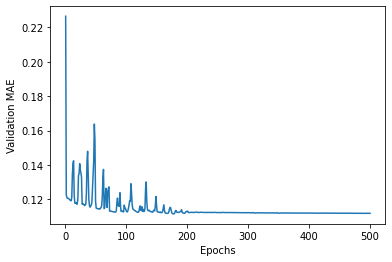

Processing fold #1


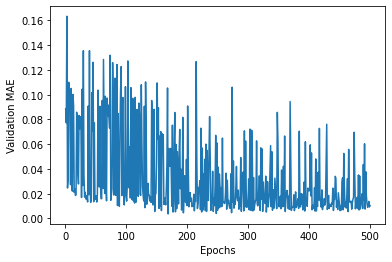

Processing fold #2


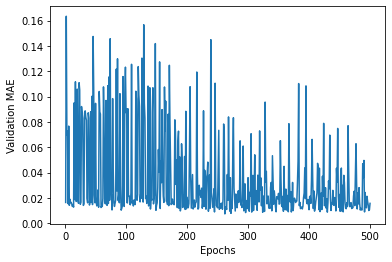

Processing fold #3


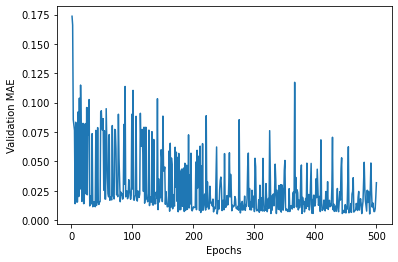

In [22]:

    '''
    Saving the validation logs at each fold
    '''
    # https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter04_getting-started-with-neural-networks.ipynb
    # https://colab.research.google.com/github/codingalzi/mle/blob/master/notebooks/dle04_getting_started_with_neural_networks.ipynb#scrollTo=A7LZNQc7chMU
    
    num_epochs = 500
    # num_epochs = 5
    all_mae_histories = []
    for i in range(k):
        print(f"Processing fold #{i}")
        val_data = X[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = y[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = np.concatenate(
            [X[:i * num_val_samples],
                X[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [y[:i * num_val_samples],
                y[(i + 1) * num_val_samples:]],
            axis=0)
        model = build_model()
        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=0)
        mae_history = history.history["val_mae"]
        all_mae_histories.append(mae_history)
        ## Fold별 그래프 표시하기 위해 추가함
        plt.plot(range(1, len(mae_history) + 1), mae_history)
        plt.xlabel("Epochs")
        plt.ylabel("Validation MAE")
        #plt.ylim([0, 0.30])
        plt.show()

In [23]:
    # Building the history of successive mean K-fold validation scores
    average_mae_history = [
        np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

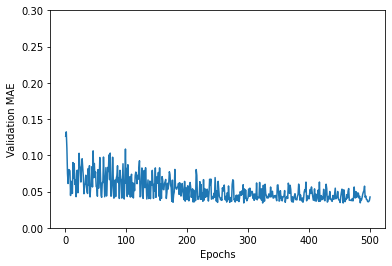

In [24]:
    # Plotting validation scores
    plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
    plt.xlabel("Epochs")
    plt.ylabel("Validation MAE")
    plt.ylim([0, 0.30])
    plt.show()

In [25]:
test_mse_score, test_mae_score = model.evaluate(X_train_test, y_train_test)
test_mae_score

1/1 [==============================] - 0s 22ms/step - loss: 0.0326 - mae: 0.0886


0.08864706754684448

In [26]:
y_train_test

array([[0],
       [0],
       [0],
       [1]])

In [27]:
predictions = model.predict(X_train_test[3])
predictions[0]

array([0.03512386], dtype=float32)